In [1]:
from jax.config import config

from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_preparer.data_preparer import DataPreparer

## Prepare data

In [2]:
project_name = "data"
simulation_name = "sinusoidal_direct"
system_name = "sinusoidal"
use_existing_params = False

In [3]:
data_preparer = DataPreparer(
    project_name, simulation_name, class_data_generator=Sinusoidal
)

In [4]:
data_preparer.create_directory()

In [5]:
data_preparer.load_params(
    system_name=system_name, use_existing_params=use_existing_params
)

In [6]:
data_preparer.params_generate_training, data_preparer.params_generate_test, data_preparer.params_main

({'difp_loc': 'inlet_outlet',
  'difp_num': 16,
  'difp_pad': 0.03,
  'difu_num': 16,
  'div_num': 44,
  'div_pad': 0.03,
  'f_num': 44,
  'f_pad': 0.03,
  'p_num': 0,
  'u_num': 44,
  'without_f': False,
  'sigma2_noise': None,
  'u_1D2C': False},
 {'infer_p': False,
  'test_num': 18,
  'use_fem_result': True,
  'use_spm_result': False,
  'ux_test': 0,
  'infer_governing_eqs': False,
  'infer_du_boundary': False,
  'infer_du_grid': False},
 {'model': {'add_noise': False,
   'init_kernel_hyperparameter': {'uxux': [1.2, -1.2, -1.2],
    'uyuy': [1.2, -1.2, -1.2],
    'pp': [1.2, -1.2, -1.2],
    'uxuy': [0.0, -1.2, -1.2],
    'uxp': [0.0, -1.2, -1.2],
    'uyp': [0.0, -1.2, -1.2]},
   'kernel_form': 'product',
   'kernel_type': 'se',
   'distance_func': False,
   'epsilon': 1e-06,
   'input_dim': 2,
   'system_type': 'Stokes_2D',
   'index_optimize_noise': None},
  'optimization': {'eps': 0.0001,
   'loss_ridge_regression': False,
   'lr': 1e-05,
   'maxiter_GD': 0,
   'maxiter_scipy': 

In [20]:

data_preparer.params_main["model"]["init_kernel_hyperparameter"] = {
    "uxux": [0.0, -1.0, -1.0],
    "uyuy": [0.0, -1.0, -1.0],
    "pp": [0.0, -1.0, -1.0],
    # "uxuy": [0.0, 0.0, 0.0]
    # "noise": float(np.log(1.0e-06)),
}
data_preparer.params_main["optimization"]["maxiter_GD"] = 5000  # 5000
data_preparer.params_main["optimization"]["lr"] = 1.0e-02  # 1e-02
data_preparer.params_main["optimization"]["maxiter_scipy"] = [0]
data_preparer.params_main["optimization"]["eps"] = 0.0001
data_preparer.params_main["optimization"]["print_process"] = False
data_preparer.params_generate_training["u_num"] = 30
data_preparer.params_generate_training["f_num"] = 20
data_preparer.params_generate_training["div_num"] = 20
data_preparer.params_generate_training["difu_num"] = 8
data_preparer.params_generate_training["difp_num"] = 8


In [21]:
data_preparer.update_params()
data_preparer.params_kernel_arg = ["uxux", "uyuy", "pp"]

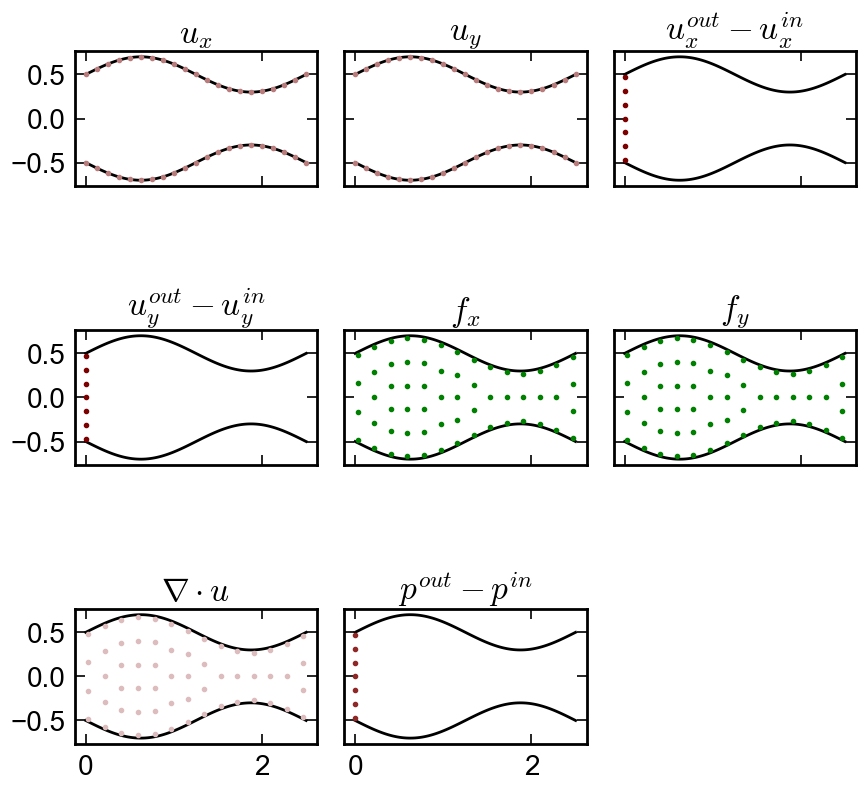

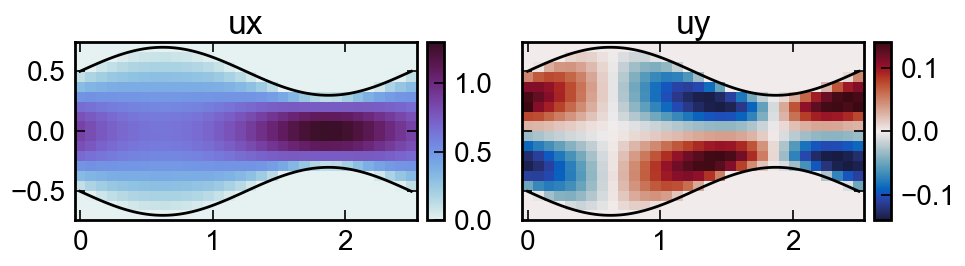

In [22]:
data_preparer.make_data(
        show_train_plot=True,
        show_test_plot=True,
        save_data=True,
        save_train_plot=True,
        save_test_plot=True,
)

In [23]:
data_preparer.save_params_prepare()
data_preparer.save_params_main()
data_preparer.save_lbls()

## Run simulation

In [24]:
import copy
import time
from functools import partial

import jax.numpy as jnp
import yaml
from jax import grad, jit
from jax.config import config

from stopro.analyzer.analysis import analyze_error_interval, analyze_result
from stopro.analyzer.make_each_plot import *
from stopro.data_handler.data_handle_module import *
from stopro.GP.gp_sinusoidal_independent import GPSinusoidalWithoutPIndependent
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam
from stopro.sub_modules.init_modules import get_init, reshape_init
from stopro.sub_modules.load_modules import load_data, load_params
from stopro.sub_modules.loss_modules import hessian, logposterior

In [25]:
data_path = "data/sinusoidal_direct"

# load params
params_main, params_prepare, lbls = load_params(
    params_path=f"{data_path}/data_input"
)
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

In [26]:
# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)
if params_model["kernel_type"] == "sm":
    init = reshape_init(init, params_kernel_arg)

In [27]:
# prepare data
hdf_operator = HdfOperator(data_path)
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [28]:
# setup model
Kernel = define_kernel(params_model)
gp_model = GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [29]:
############## training ####################
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

: 

: 

: 